In [1]:
import pandas as pd
from astro.config import Config
from pathlib import Path
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [16]:
paths = Config.from_env()

df = pd.read_csv(paths.derived_data_dir / "atd_decoding" / "neuron_number_scores.csv")
df = df.sort_values("neuron_number")

df_rot = pd.read_csv(
    paths.derived_data_dir / "atd_decoding" / "neuron_number_scores_rot.csv"
)
df_rot = (
    df_rot.groupby(["neuron_number", "group"], as_index=False)["mean_test_score"]
    .median()
    .rename(columns={"mean_test_score": "chance"})
)

df = df.merge(df_rot).assign(
    adjusted_score=lambda x: x["mean_test_score"] - x["chance"]
)

## Independent

In [45]:
from scipy import stats


def model_function(N, a, b):
    """
    Saturation model function


    """
    return (b * N) / (a + N)


GROUPS = ["VEH-CNO", "CNO-VEH"]
results = {}
for group in GROUPS:
    df1 = df.loc[lambda x: x.group == group]

    N = df1["neuron_number"].values
    y = df1["mean_test_score"].values

    opt_params, params_cov = curve_fit(model_function, N, y, bounds=(0, [2, 100]))
    results[group] = {"opt_params": opt_params, "params_cov": params_cov}


for group in GROUPS:
    results[group]["a_se"] = np.sqrt(results[group]["params_cov"][0, 0])
    results[group]["b_se"] = np.sqrt(results[group]["params_cov"][1, 1])

diff_in_a = results["VEH-CNO"]["opt_params"][0] - results["CNO-VEH"]["opt_params"][0]
se_diff_in_a = np.sqrt(
    results["VEH-CNO"]["a_se"] ** 2 + results["CNO-VEH"]["a_se"] ** 2
)
t = diff_in_a / se_diff_in_a

dof = 2 * (len(df1) - 1)
p = stats.t.sf(np.abs(t), dof) * 2

print(f"t = {t:.2f}, p = {p:.2f}")

t = 3.97, p = 0.00


In [46]:
def describe_params(result_dict, group1, group2) -> pd.DataFrame:
    """
    Return a dataframe with one row for each param and columns for its:
    - param type
    - group
    - estimated value
    - standard error
    - 95 ci
    """
    results = []
    for group in (group1, group2):
        params_cov = result_dict[group]["params_cov"]
        a, b = result_dict[group]["opt_params"]
        a_se = np.sqrt(params_cov[0, 0])
        b_se = np.sqrt(params_cov[1, 1])
        results.append(
            {
                "group": group,
                "param": "a",
                "value": a,
                "se": a_se,
                "ci_95": (round(a - 1.96 * a_se, 2), round(a + 1.96 * a_se, 2)),
            }
        )
        results.append(
            {
                "group": group,
                "param": "b",
                "value": b,
                "se": b_se,
                "ci_95": (round(b - 1.96 * b_se, 2), round(b + 1.96 * b_se, 2)),
            }
        )
    return pd.DataFrame(results)


def compute_contrasts(result_dict, group1, group2, n) -> pd.DataFrame:
    """
    Compute the difference in a and b across the two groups
    """

    results = []

    for i, param in enumerate(("a", "b")):
        group1_val = result_dict[group1]["opt_params"][i]
        group2_val = result_dict[group2]["opt_params"][i]

        group1_se = np.sqrt(result_dict[group1]["params_cov"][i, i])
        group2_se = np.sqrt(result_dict[group2]["params_cov"][i, i])

        diff = group1_val - group2_val
        se_diff = np.sqrt(group1_se**2 + group2_se**2)
        t = diff / se_diff
        dof = 2 * (n - 1)
        p = stats.t.sf(np.abs(t), dof) * 2

        results.append(
            {
                f"{group1}_val": group1_val,
                f"{group2}_val": group2_val,
                "param": param,
                "diff": diff,
                "se_diff": se_diff,
                "t": t,
                "p": p,
            }
        )

    return pd.DataFrame(results)


display(describe_params(results, "VEH-CNO", "CNO-VEH").round(2))
display(compute_contrasts(results, "VEH-CNO", "CNO-VEH", len(df1)).round(2))

,group,param,value,se,ci_95
0,VEH-CNO,a,1.32,0.06,"(1.19, 1.44)"
1,VEH-CNO,b,0.77,0.00,"(0.77, 0.78)"
2,CNO-VEH,a,0.95,0.07,"(0.81, 1.08)"
3,CNO-VEH,b,0.64,0.00,"(0.64, 0.65)"


,VEH-CNO_val,CNO-VEH_val,param,diff,se_diff,t,p
0,1.32,0.95,a,0.37,0.09,3.97,0.0
1,0.77,0.64,b,0.13,0.00,39.71,0.0


/opt/miniconda3/envs/astro/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/miniconda3/envs/astro/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/miniconda3/envs/astro/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/miniconda3/envs/astro/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype

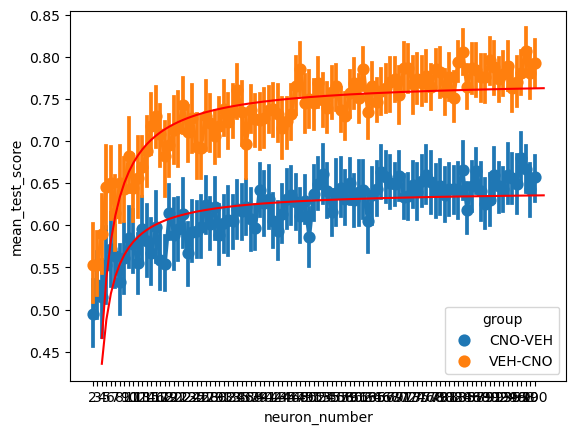

In [48]:
f, ax = plt.subplots()

sns.pointplot(data=df, x="neuron_number", y="mean_test_score", ax=ax, hue="group")

for group in GROUPS:
    opt_params = results[group]["opt_params"]
    params_cov = results[group]["params_cov"]
    ax.plot(N, model_function(N, *opt_params), label=f"Fit-{group}", color="red")

/opt/miniconda3/envs/astro/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/miniconda3/envs/astro/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/miniconda3/envs/astro/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/miniconda3/envs/astro/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype

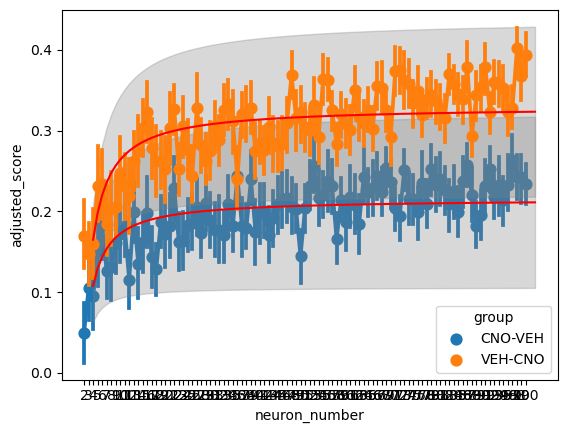

In [19]:
from scipy import stats

f, ax = plt.subplots()

sns.pointplot(data=df, x="neuron_number", y="adjusted_score", ax=ax, hue="group")

for group in GROUPS:
    opt_params = results[group]["opt_params"]
    params_cov = results[group]["params_cov"]

    ax.plot(N, model_function(N, *opt_params), label=f"Fit-{group}", color="red")
    # Calculate the upper and lower bounds of the 95% CI
    # Calculate the Jacobian matrix of the model function
    jacobian = np.array(
        [
            model_function(N, *(opt_params + np.eye(len(opt_params))[i]))
            for i in range(len(opt_params))
        ]
    )

    # Calculate the variance of the y-values
    y_var = np.diag(jacobian.T @ params_cov @ jacobian)

    # Calculate the 95% CI
    ci = stats.norm.ppf(0.95) * np.sqrt(y_var)
    ci_upper = model_function(N, *opt_params) + ci
    ci_lower = model_function(N, *opt_params) - ci

    # Plot the 95% CI
    ax.fill_between(N, ci_lower, ci_upper, color="gray", alpha=0.3)
plt.show()

In [21]:
ci = 1.96 * np.sqrt(np.diag(params_cov))
ci

array([0.12557608, 0.00462937])

## Independent - Error

## Joint

## Joint - Error